<a href="https://colab.research.google.com/github/OczyDimon/ML_2025_autumn/blob/main/homework-01-PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import os
import shutil
import gzip
from six.moves import urllib

# CVDF mirror of http://yann.lecun.com/exdb/mnist/
DEFAULT_SOURCE_URL = 'https://storage.googleapis.com/cvdf-datasets/mnist/'

def _read32(bytestream):
    dt = np.dtype(np.uint32).newbyteorder('>')
    return np.frombuffer(bytestream.read(4), dtype=dt)[0]


def extract_images(f):
    """Extract the images into a 4D uint8 numpy array [index, y, x, depth].
    Args:
      f: A file object that can be passed into a gzip reader.
    Returns:
      data: A 4D uint8 numpy array [index, y, x, depth].
    Raises:
      ValueError: If the bytestream does not start with 2051.
    """
    print('Extracting', f.name)
    with gzip.GzipFile(fileobj=f) as bytestream:
        magic = _read32(bytestream)
        if magic != 2051:
            raise ValueError('Invalid magic number %d in MNIST image file: %s' %(magic, f.name))
        num_images = _read32(bytestream)
        rows = _read32(bytestream)
        cols = _read32(bytestream)
        buf = bytestream.read(rows * cols * num_images)
        data = np.frombuffer(buf, dtype=np.uint8)
        data = data.reshape(num_images, rows, cols, 1)
        return data


def dense_to_one_hot(labels_dense, num_classes):
    """Convert class labels from scalars to one-hot vectors."""
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot


def extract_labels(f, one_hot=False, num_classes=10):
    """Extract the labels into a 1D uint8 numpy array [index].
    Args:
      f: A file object that can be passed into a gzip reader.
      one_hot: Does one hot encoding for the result.
      num_classes: Number of classes for the one hot encoding.
    Returns:
      labels: a 1D uint8 numpy array.
    Raises:
      ValueError: If the bystream doesn't start with 2049.
    """
    print('Extracting', f.name)
    with gzip.GzipFile(fileobj=f) as bytestream:
        magic = _read32(bytestream)
        if magic != 2049:
            raise ValueError('Invalid magic number %d in MNIST label file: %s' %(magic, f.name))
        num_items = _read32(bytestream)
        buf = bytestream.read(num_items)
        labels = np.frombuffer(buf, dtype=np.uint8)
        if one_hot:
            return dense_to_one_hot(labels, num_classes)
        return labels


def maybe_download(filename, work_directory, source_url):
    """Download the data from source url, unless it's already here.
    Args:
          filename: string, name of the file in the directory.
          work_directory: string, path to working directory.
          source_url: url to download from if file doesn't exist.
    Returns:
          Path to resulting file.
    """
    os.path.exists
    if not os.path.exists(work_directory):
        os.makedirs(work_directory)
    filepath = os.path.join(work_directory, filename)
    if not os.path.exists(filepath):
        temp_file_name, _ = urllib.request.urlretrieve(source_url, None)
        shutil.copy (temp_file_name, filepath)
        with open(filepath, 'rb') as f:
            f.seek(0, 2)
            size = f.tell()
            print('Successfully downloaded', filename, size, 'bytes.')
    return filepath


def read_MNIST_datasets(train_dir,
                   one_hot=False,
                   dtype=np.float32,
                   reshape=True,
                   validation_size=5000,
                   seed=None,
                   source_url=DEFAULT_SOURCE_URL):

    if not source_url:  # empty string check
        source_url = DEFAULT_SOURCE_URL

    TRAIN_IMAGES = 'train-images-idx3-ubyte.gz'
    TRAIN_LABELS = 'train-labels-idx1-ubyte.gz'
    TEST_IMAGES = 't10k-images-idx3-ubyte.gz'
    TEST_LABELS = 't10k-labels-idx1-ubyte.gz'

    local_file = maybe_download(TRAIN_IMAGES, train_dir,
                                   source_url + TRAIN_IMAGES)
    with open(local_file, 'rb') as f:
        train_images = extract_images(f)

    local_file = maybe_download(TRAIN_LABELS, train_dir,
                                   source_url + TRAIN_LABELS)
    with open(local_file, 'rb') as f:
        train_labels = extract_labels(f, one_hot=one_hot)

    local_file = maybe_download(TEST_IMAGES, train_dir,
                                   source_url + TEST_IMAGES)
    with open(local_file, 'rb') as f:
        test_images = extract_images(f)

    local_file = maybe_download(TEST_LABELS, train_dir,
                                   source_url + TEST_LABELS)
    with open(local_file, 'rb') as f:
        test_labels = extract_labels(f, one_hot=one_hot)

    if not 0 <= validation_size <= len(train_images):
        raise ValueError('Validation size should be between 0 and {}. Received: {}.'.format(len(train_images), validation_size))

    validation_images = train_images[:validation_size]
    validation_labels = train_labels[:validation_size]
    train_images = train_images[validation_size:]
    train_labels = train_labels[validation_size:]

    train = (train_images, train_labels)
    validation = (validation_images, validation_labels)
    test = (test_images, test_labels)

    return train, validation, test


def load_mnist(train_dir='MNIST-data'):
    return read_MNIST_datasets(train_dir)

In [3]:
train, validation, test = load_mnist()

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


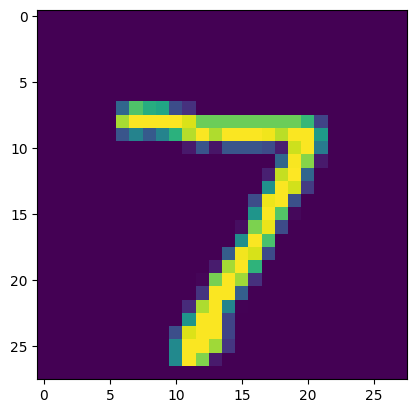

In [4]:
plt.imshow(test[0][0])

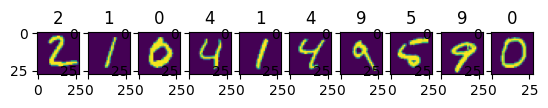

In [5]:
for i in range(1, 11):
  plt.subplot(1, 10, i)
  plt.imshow(test[0][i])
  plt.title(test[1][i])

In [6]:
X, Y = train[0], train[1]

In [7]:
class my_PCA():
 def __init__(self, n_components=None):
  pass

 def fit(self, X):
  X = np.reshape(X, (-1, 784)).astype(np.float32)

  Xs = np.tile(np.mean(X, axis=0), (55000, 1))

  Xc = X - Xs

  C = Xc.T @ Xc

  lambdas = np.linalg.eig(C)

  F = lambdas[1].T

  return  F, lambdas[0], C, Xc

 def transform(self, X):
  F, lambdas, C, Xc = self.fit(X)
  return Xc @ F

 def fit_transform(self, X):
  pass


In [8]:
PCA = my_PCA(15)

In [9]:
F, lambdas, C, Xc = PCA.fit(X)

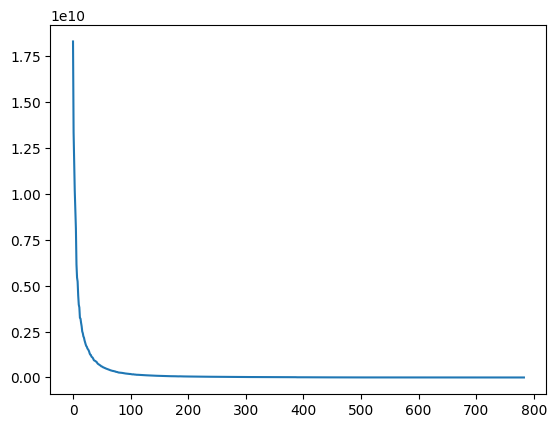

In [10]:
plt.plot(lambdas)
plt.show()

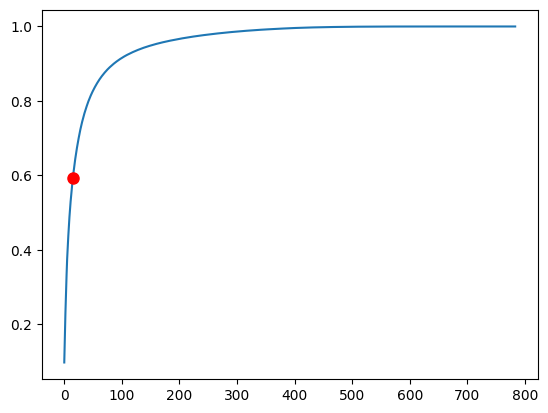

In [11]:
cumsum = np.cumsum(lambdas)
fullsum = np.sum(lambdas)

plt.plot(cumsum/fullsum)
plt.plot(15, cumsum[15]/fullsum, 'ro', markersize=8)
plt.show()

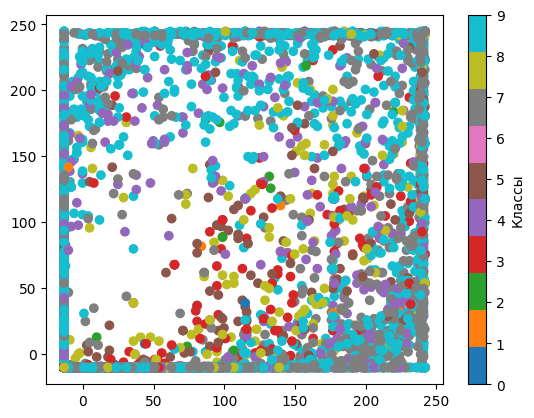

In [12]:
Y_new = PCA.transform(X).T

x1, x2 = Y_new[:2]


scatter = plt.scatter(x1, x2, c=Y, cmap='tab10')
plt.colorbar(scatter, label='Классы')
plt.show()


kNN

In [13]:
class my_kNN():
 def __init__(self, n_neighbors=5):
  self.n_neighbors = n_neighbors
 def fit(self, X, y):
  self.X = X
  self.y = y
 def predict(self, X):
  res = []
  for x in X:
    distances = np.sqrt(np.sum((self.X - x) ** 2, axis=1))
    k_nearest_indexes = np.argsort(distances)[:self.n_neighbors]
    targets = self.y[k_nearest_indexes].flatten()
    res.append(np.bincount(targets).argmax())
  return np.arr(res)


In [14]:
from sklearn.metrics import accuracy_score

In [15]:
kNN = my_kNN(5)


In [16]:
kNN.fit(X, Y)

In [ ]:
x_test, y_test = test
y_res = kNN.predict(x_test)

acc = accuracy_score(y_test, y_res)
acc